In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Load the fine-tuned model and tokenizer
model_path = "/content/drive/MyDrive/fine_tuned_marbert_V3"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define label mapping (ensure it matches the training labels)
label_mapping = {
    0: 'Normal',
    1: 'Anxiety',
    2: 'Depression',
    3: 'Suicidal',
    4: 'Stress'
}

In [ ]:
# Load the new posts Excel file
input_file = "/content/drive/MyDrive/cleaned_reddit_posts.xlsx"  # Replace with your file path
df_posts = pd.read_excel(input_file)
df_posts = df_posts.dropna().reset_index(drop=True)  # Remove null values

# Ensure the column with posts is named "statement"
print(df_posts.head())  # Check the structure

                                           statement
0                        الف صحتين   شي بيشهي والله 
1  الحزب ضحي بقياداته دفاعا عن لبنان وامتنع عن قت...
2              الرجل لقد صنعت اريا  طبق بنجر فلسطيني
3  لان بيبسيكو يساهمون بنشاط في احتيال اسراءيلي و...
4  لا روح خلف تلك العيون  حياه كامله مخصصه لسرقه ...


In [ ]:
# Function to classify posts
def classify_post(statement):
    tokens = tokenizer(statement, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    tokens = {key: value.to(device) for key, value in tokens.items()}  # Move tensors to the appropriate device
    with torch.no_grad():
        outputs = model(**tokens)
    prediction = torch.argmax(outputs.logits, dim=1).item()  # Get the predicted label index
    return label_mapping[prediction]

# Classify all posts
df_posts['predicted_label'] = df_posts['statement'].apply(classify_post)
print(df_posts.head())  # Check predictions

                                           statement predicted_label
0                        الف صحتين   شي بيشهي والله           Normal
1  الحزب ضحي بقياداته دفاعا عن لبنان وامتنع عن قت...          Normal
2              الرجل لقد صنعت اريا  طبق بنجر فلسطيني          Normal
3  لان بيبسيكو يساهمون بنشاط في احتيال اسراءيلي و...          Normal
4  لا روح خلف تلك العيون  حياه كامله مخصصه لسرقه ...      Depression


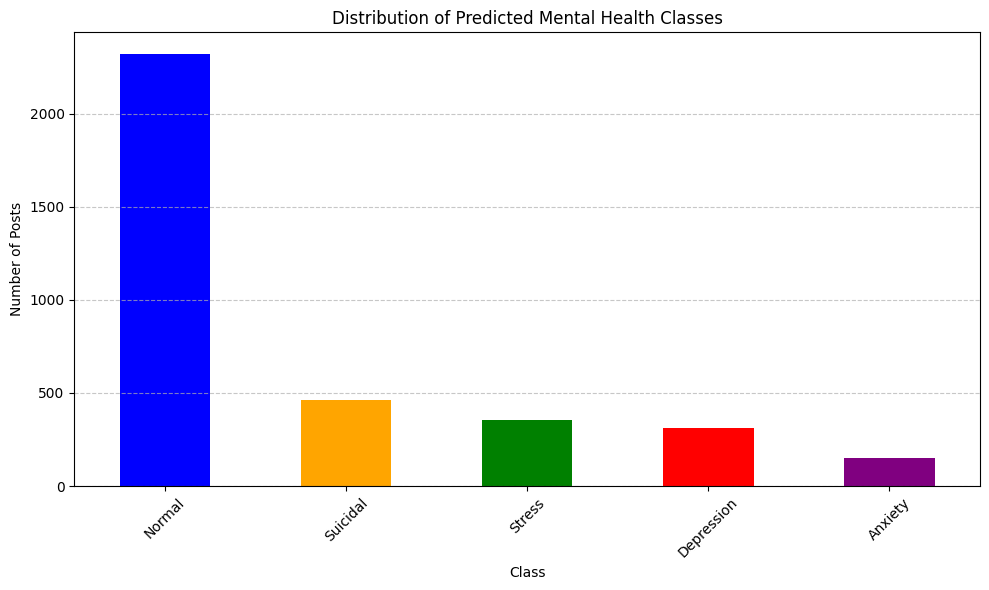

In [ ]:
# Count the occurrences of each class
class_counts = df_posts['predicted_label'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title("Distribution of Predicted Mental Health Classes")
plt.xlabel("Class")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
output_file = "/content/drive/MyDrive/classified_posts.xlsx"
df_posts.to_excel(output_file, index=False)
print(f"Classified posts saved to: {output_file}")

Classified posts saved to: /content/drive/MyDrive/classified_posts.xlsx


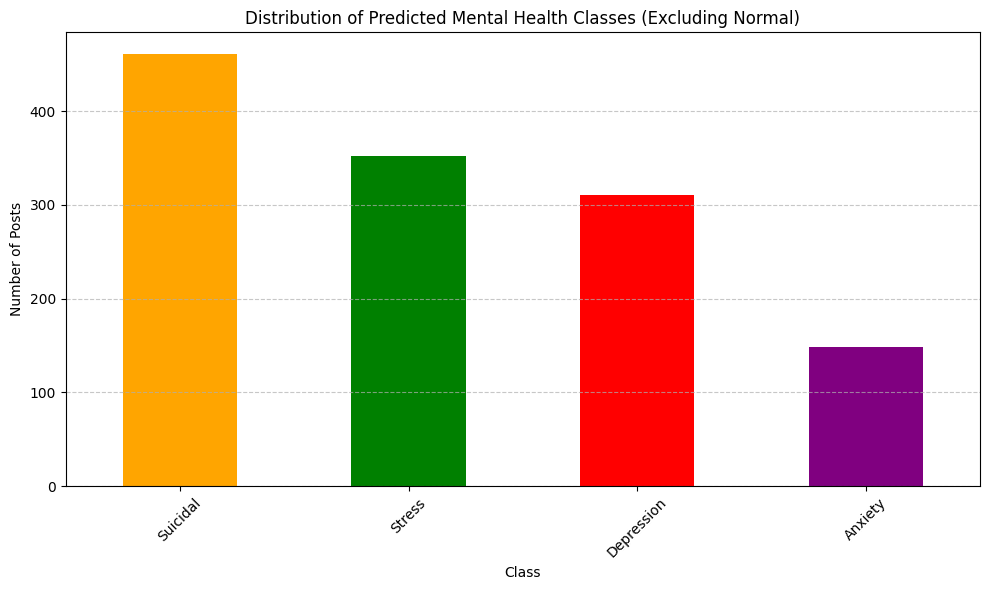

In [ ]:
# Filter out the "Normal" class
filtered_class_counts = class_counts[class_counts.index != "Normal"]

# Plot the bar chart without the "Normal" class
plt.figure(figsize=(10, 6))
filtered_class_counts.plot(kind='bar', color=['orange', 'green', 'red', 'purple'])
plt.title("Distribution of Predicted Mental Health Classes (Excluding Normal)")
plt.xlabel("Class")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()